In [4]:
import os, glob, numpy as np
import pandas as pd
from astropy.io import fits
from astropy.wcs import WCS
from astropy.cosmology import Planck18 as cosmo
import astropy.units as u

# --------- constants ----------
z   = 0.016268                        # redshift of NGC 7469
D_A = cosmo.angular_diameter_distance(z).to(u.pc)  # convert once to pc

# --------- where the FITS cubes live ----------
folder_path = r"C:\Users\vinay\OneDrive\Desktop\Summer School\Projects\JWST MIRI\MAST_2025-06-28T1540\JWST\jw01328-c1006_t014_miri_ch1-short\data"
fits_files  = glob.glob(os.path.join(folder_path, "*.fits"))

print(f"📁 {len(fits_files)} FITS cubes found")

rows = []
for fname in fits_files:
    print("→", os.path.basename(fname))
    try:
        hdul = fits.open(fname)

        # --- grab a header that *does* have a WCS ---
        header = None
        for ext in ('SCI', 'SCI,1', 'DATA', 1, 0):
            try:
                header = hdul[ext].header
                wcs    = WCS(header)
                break
            except Exception:
                continue
        if header is None:
            print("   ⚠ no WCS – skipped")
            continue

        # --- pixel scale in degrees/pixel (take only the spatial 2×2 part) ---
        # proj_plane_pixel_scales() is the safest helper:
        scale_deg = wcs.proj_plane_pixel_scales()[:2]        # 2 values (RA,Dec)
        # take RMS to get an average single value (arc-sec / pix)
        pixscale_arcsec = np.hypot(*scale_deg) * u.deg.to(u.arcsec)

        # --- convert to parsec / pixel ---
        theta = pixscale_arcsec * u.arcsec
        # use `dimensionless_angles()` so rad→1
        pixscale_pc = (theta * D_A).to(u.pc,
                        equivalencies=u.dimensionless_angles()).value

        rows.append(dict(File=os.path.basename(fname),
                         PixScale_arcsec=round(pixscale_arcsec, 4),
                         PixScale_pc=round(pixscale_pc, 2)))

        hdul.close()

    except Exception as e:
        print("   ⚠", e)

# ---------- tabulate ----------
df = pd.DataFrame(rows)
print("\n✅ pixel-scale summary\n", df)
df.to_csv("pixel_scale_summary.csv", index=False)
print("\n📄  results written to pixel_scale_summary.csv")


📁 12 FITS cubes found
→ jw01328-c1006_t014_miri_ch1-long_s3d.fits
→ jw01328-c1006_t014_miri_ch1-medium_s3d.fits
→ jw01328-c1006_t014_miri_ch1-short_s3d.fits
→ jw01328-c1006_t014_miri_ch2-long_s3d.fits
→ jw01328-c1006_t014_miri_ch2-medium_s3d.fits
→ jw01328-c1006_t014_miri_ch2-short_s3d.fits
→ jw01328-c1006_t014_miri_ch3-long_s3d.fits
→ jw01328-c1006_t014_miri_ch3-medium_s3d.fits
→ jw01328-c1006_t014_miri_ch3-short_s3d.fits
→ jw01328-c1006_t014_miri_ch4-long_s3d.fits
→ jw01328-c1006_t014_miri_ch4-medium_s3d.fits
→ jw01328-c1006_t014_miri_ch4-short_s3d.fits

✅ pixel-scale summary
                                            File PixScale_arcsec  PixScale_pc
0     jw01328-c1006_t014_miri_ch1-long_s3d.fits      0.1838 deg         1.10
1   jw01328-c1006_t014_miri_ch1-medium_s3d.fits      0.1838 deg         1.10
2    jw01328-c1006_t014_miri_ch1-short_s3d.fits      0.1838 deg         1.10
3     jw01328-c1006_t014_miri_ch2-long_s3d.fits      0.2404 deg         1.44
4   jw01328-c1006_t014_miri_c

In [5]:
%pip install regions astropy regions[ds9]

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
%pip install spectral-cube regions

import os
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy.wcs import WCS
from regions import Regions
import numpy as np
import pandas as pd

# --- Input paths ---
cube_path = "jw01328-c1006_t014_miri_ch1-short_s3d.fits"
reg_paths = ["Region 1.reg", "Region 2.reg"]  # Make sure these files exist

output_dir = "spectra_outputs"
os.makedirs(output_dir, exist_ok=True)

# --- Load the FITS Cube ---
cube = SpectralCube.read(cube_path, hdu='SCI')
wcs = cube.wcs

# --- Process each region ---
for reg_file in reg_paths:
    if not os.path.exists(reg_file):
        print(f"⚠ Region file not found: {reg_file} — skipping.")
        continue

    regions = Regions.read(reg_file, format='ds9')

    # Apply the spatial region mask
    masked_cube = cube.subcube_from_regions(regions)

    # Collapse spatially (mean over all pixels)
    spectrum = masked_cube.mean(axis=(1, 2))

    # Get spectral axis in microns
    wavelengths = cube.spectral_axis.to('micron').value
    flux = spectrum.value

    # Save to CSV
    regname = os.path.splitext(os.path.basename(reg_file))[0]
    df = pd.DataFrame({
        'Wavelength (micron)': wavelengths,
        'Flux': flux
    })
    out_path = os.path.join(output_dir, f"spectrum_{regname}.csv")
    df.to_csv(out_path, index=False)
    print(f"✅ Saved spectrum to: {out_path}")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
✅ Saved spectrum to: spectra_outputs\spectrum_Region 1.csv
✅ Saved spectrum to: spectra_outputs\spectrum_Region 2.csv


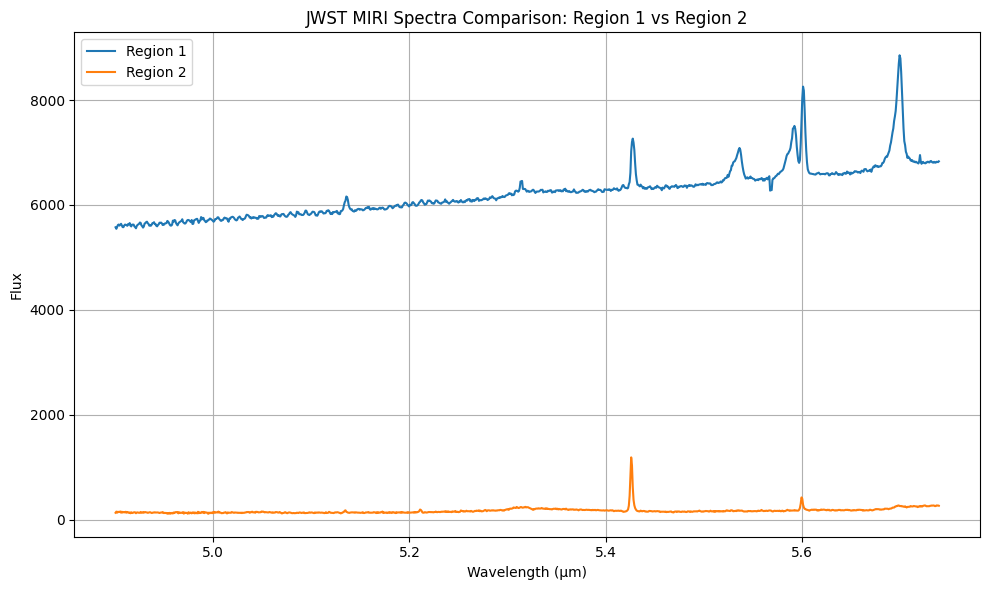

In [10]:
import matplotlib.pyplot as plt

df1 = pd.read_csv("spectra_outputs/spectrum_centre_region.csv")
df2 = pd.read_csv("spectra_outputs/spectrum_ring_region.csv")

plt.figure(figsize=(10, 6))
plt.plot(df1["Wavelength (micron)"], df1["Flux"], label="Region 1")
plt.plot(df2["Wavelength (micron)"], df2["Flux"], label="Region 2")

plt.xlabel("Wavelength (μm)")
plt.ylabel("Flux")
plt.title("JWST MIRI Spectra Comparison: Region 1 vs Region 2")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()
